Ref: https://arxiv.org/pdf/1711.10561

# Equação de Burgers

$$\left\{\begin{array}{l}
u_t + u u_x - (0.01/\pi) u_{xx} = 0, \ x \in [-1,1], \ t \in [0,1] \\
u(x,0) = -\sin(\pi x) \\
u(-1,t) = u(1,t) = 0
\end{array}\right.$$

#### Setup Inicial

In [1]:
#### Importando Bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import torch as tc

from time import perf_counter
from torch import nn
from torch.optim.lr_scheduler import StepLR
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp

# Detecção de GPU
device = tc.device('cuda' if tc.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cpu


#### Geração de Dados

dx = 0.001955, dt = 0.000100
Condição CFL difusão: 0.1666 (deve ser < 1)
Condição CFL convecção: 0.0512 (deve ser < |u_max|)


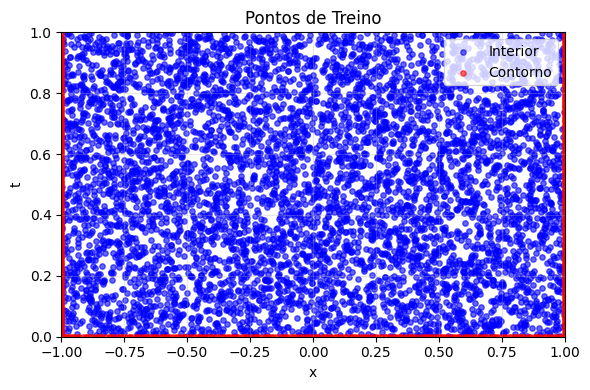

In [ ]:
tc.manual_seed(21)

# Definindo domínio
x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0

# Número de pontos
n_ci = 200   # Pra cada condição de contorno(teste)
n = 10000    # Pontos usados no treino, validação e teste

distribution = [0.6, 0.2, 0.2] # Distribuição entre treino, validação e teste

# Hipercubo Latino 2D (para (x,t) ∈ [(x_min, x_max), (t_min, t_max)])
def latin_hypercube(n_points):
    intervals = tc.linspace(0, 1, n_points + 1)
    points = tc.zeros(n_points, 2)
    for i in range(2):
        perm = tc.randperm(n_points)
        points[:, i] = intervals[:-1] + (intervals[1] - intervals[0]) * tc.rand(n_points)
        points[:, i] = points[perm, i]
    
    # Escalar para o domínio definido
    points[:, 0] = points[:, 0] * (x_max - x_min) + x_min # x
    points[:, 1] = points[:, 1] * (t_max - t_min) + t_min # t
    return points

### ================================== ###
###    Condições Iniciais/Contorno     ###
### ================================== ###

# Pontos (x,t)
ci1 = latin_hypercube(n_ci)     # (x,t) = (:,0)
ci2 = latin_hypercube(n_ci)     # (x,t) = (1,:)
ci3 = latin_hypercube(n_ci)     # (x,t) = (-1,:)

ci1[:,1] = tc.zeros(n_ci)           # t = 0
ci2[:,0] = tc.full((n_ci,), 1.0)    # x = 1
ci3[:,0] = tc.full((n_ci,), -1.0)   # x = -1

treino_ci = tc.concatenate([ci1, ci2, ci3]) # (x,t) -> shape: [3*n_ci, 2]

# Soluções u(x,t)
ci1_u = -tc.sin(tc.pi*ci1[:,0])     # u(x,0) -> shape: [n_ci]
ci2_u = tc.zeros(n_ci)              # u(1,t) -> shape: [n_ci]
ci3_u = tc.zeros(n_ci)              # u(-1,t) -> shape: [n_ci]

treino_ci_u = tc.concatenate([ci1_u, ci2_u, ci3_u]).unsqueeze(1).to(device) # (x,t) -> shape: [3*n_ci, 1]

### ==================================== ###
###  Dados de treino, validação e teste  ###
### ==================================== ###

n_treino = int(n*distribution[0])
n_validacao = int(n*distribution[1])
n_teste = int(n*distribution[2])

# Pontos (x,t) - treino
treino_geral = latin_hypercube(n_treino)               # (x,t) -> shape: [n_treino, 2]
treino = tc.cat([treino_ci, treino_geral]).to(device)  # (x,t) -> shape: [3*n_ci + n_treino, 2]
treino.requires_grad_(True)

# Pontos (x,t) - validação
validacao = latin_hypercube(n_validacao).to(device)    # (x,t) -> shape: [n_validacao, 2]

# Pontos (x,t) - teste
teste = latin_hypercube(n_teste).to(device)            # (x,t) -> shape: [n_teste, 2]

### ========================================= ###
###   Solução Referencia(validação e teste)   ###
### ========================================= ###

# Parâmetros da malha de referência
nx = 1024      # Aumentado para melhor resolução espacial
nt = 10001     # Aumentado para melhor estabilidade (dt menor)
x_ref = np.linspace(x_min, x_max, nx)
t_ref = np.linspace(t_min, t_max, nt)
dx = x_ref[1] - x_ref[0]
dt = t_ref[1] - t_ref[0]
nu = 0.01 / np.pi

# Verificação da condição CFL
cfl_diffusion = dt / (dx**2 / (2 * nu))
cfl_convection = dt / dx

# Inicialização da solução na malha regular
u_ref = np.zeros((nt, nx), dtype=np.float64)
u_ref[0, :] = -np.sin(np.pi * x_ref)

# Função RHS de Burgers (diferenças centrais)
def rhs(u):
    dudx = (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)
    d2udx2 = (np.roll(u, -1) - 2 * u + np.roll(u, 1)) / dx**2
    return -u * dudx + nu * d2udx2

# Integração temporal (RK4 explícito)
for n in range(nt - 1):
    u = u_ref[n]
    k1 = rhs(u)
    k2 = rhs(u + 0.5 * dt * k1)
    k3 = rhs(u + 0.5 * dt * k2)
    k4 = rhs(u + dt * k3)
    u_next = u + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    u_next[0] = 0.0
    u_next[-1] = 0.0
    u_ref[n + 1] = u_next

# Interpolador para pontos arbitrários (x, t)
interp = RegularGridInterpolator((t_ref, x_ref), u_ref, bounds_error=False, fill_value=0.0)

def get_u_tensor(points):
    # points: tensor shape [N, 2] com (x, t)
    pts_np = points.detach().cpu().numpy()
    # scipy espera (t, x)
    pts_np = np.stack([pts_np[:,1], pts_np[:,0]], axis=1)
    u_np = interp(pts_np)
    return tc.tensor(u_np, dtype=tc.float32, device=points.device).unsqueeze(1)

validacao_u = get_u_tensor(validacao)     # u(x,t) -> shape: [n_validacao, 1]
teste_u = get_u_tensor(teste)             # u(x,t) -> shape: [n_teste, 1]

### ========================================= ###
###         Plotando Pontos de Treino         ###
### ========================================= ###
plt.figure(figsize=(6, 4))

plt.scatter(treino_geral[:,0].detach().numpy(), treino_geral[:,1].detach().numpy(), c='blue', s=15, label='Interior', alpha=0.6)
plt.scatter(ci3[:,0].detach().numpy(), ci3[:,1].detach().numpy(), c='red', label='Contorno', s=15, alpha=0.6)
plt.scatter(ci2[:,0].detach().numpy(), ci2[:,1].detach().numpy(), c='red', s=15, alpha=0.6)
plt.scatter(ci1[:,0].detach().numpy(), ci1[:,1].detach().numpy(), c='red', s=15, alpha=0.6)

plt.xlabel('x')
plt.ylabel('t')
plt.title('Pontos de Treino')
plt.xlim(x_min, x_max)
plt.ylim(t_min, t_max)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Definindo rede neural

In [10]:
class PINN(nn.Module):

    def __init__(self, structure=[1, 10, 10, 1], activation=nn.Tanh()):
        super(PINN, self).__init__()
        self.structure = structure
        self.activation = activation
        self.hidden_layers = nn.ModuleList()

        for i in range(len(structure)-1):
            self.hidden_layers.append(nn.Linear(structure[i], structure[i+1]))
            
    
    def forward(self, x):
        for layer in self.hidden_layers[:-1]:
            x = self.activation(layer(x))
        x = self.hidden_layers[-1](x) # Sem ativação na última camada
        return x

#### Treino

In [ ]:
tc.manual_seed(21)

f = PINN(structure=[2] + [40] * 9 + [1]) # 9 camadas de 20 neurônios
f.to(device)

optimizer = tc.optim.Adam(f.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=250, gamma=0.9)

loss_log = []
epochs = 10000
start_time = perf_counter()

for epoch in range(epochs):
    u = f(treino) # inferencia dos dados de treino

    # Derivadas Parciais
    grad_u = tc.autograd.grad(u, treino, grad_outputs=tc.ones_like(u), create_graph=True, retain_graph=True)[0]
    du_dx = grad_u[:, 0]
    du_dt = grad_u[:, 1]
    d2u_dx2 = tc.autograd.grad(du_dx, treino, grad_outputs=tc.ones_like(du_dx), create_graph=True, retain_graph=True)[0][:, 0]

    loss_EDP = tc.mean((du_dt + u*du_dx - tc.tensor(0.01/np.pi)*d2u_dx2)**2)    # EDP
    loss_ci1 = tc.mean((u[:n_ci] - treino_ci_u[:n_ci])**2)                      # u(x,0)
    loss_ci2 = tc.mean((u[n_ci:2*n_ci] - treino_ci_u[n_ci:2*n_ci])**2)          # u(1,t)
    loss_ci3 = tc.mean((u[2*n_ci:3*n_ci] - treino_ci_u[2*n_ci:3*n_ci])**2)      # u(-1,t)
    loss_ci = loss_EDP + loss_ci1 + loss_ci2 + loss_ci3
    loss = loss_ci
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Salvando loss e printando a cada 1000 epochs
    loss_log.append([loss.item(), loss_EDP.item(), loss_ci.item()])
    if epoch % 1000 == 0:
        end_time = perf_counter()
        print(f"Epoch {epoch} - Loss: {loss.item():.2e} - Time: {end_time - start_time:.2f}s")
        start_time = perf_counter()

Epoch 0 - Loss: 6.40e-01 - Time: 4.42s
Epoch 1 - Loss: 5.19e-01 - Time: 4.51s
Epoch 2 - Loss: 5.08e-01 - Time: 4.48s
Epoch 3 - Loss: 5.03e-01 - Time: 4.56s
Epoch 4 - Loss: 5.00e-01 - Time: 4.49s
Epoch 5 - Loss: 5.06e-01 - Time: 4.47s


KeyboardInterrupt: 

#### Plot da loss

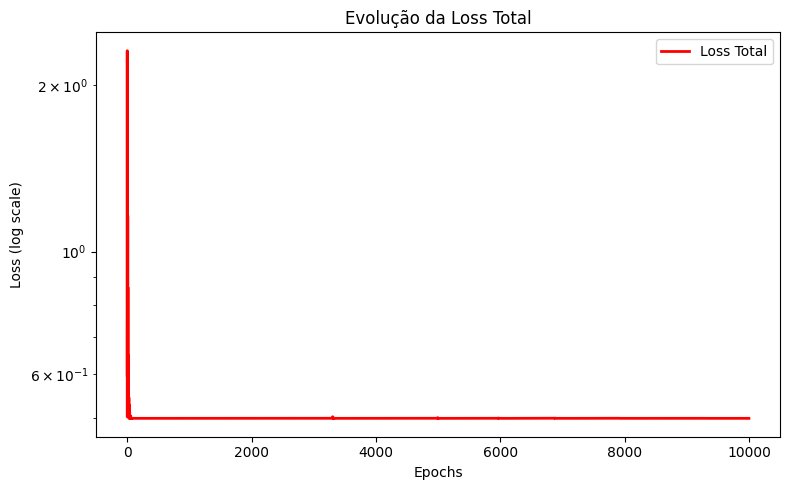

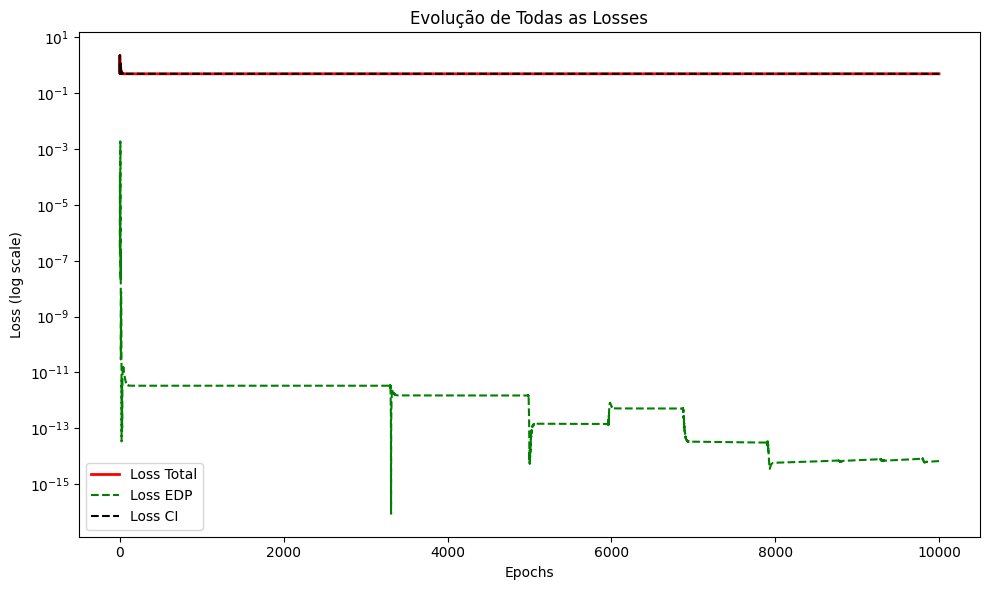

In [ ]:
loss_array = np.array(loss_log)

# Figura 1: Apenas Loss Total
plt.figure(figsize=(8,5))
plt.semilogy(loss_array[:, 0], 'r-', linewidth=2, label='Loss Total')
plt.ylabel("Loss (log scale)")
plt.xlabel("Epochs")
plt.legend()
plt.title("Evolução da Loss Total")
plt.tight_layout()
plt.show()

# Figura 2: Todas as Losses
plt.figure(figsize=(10,6))
plt.semilogy(loss_array[:, 0], 'r-', linewidth=2, label='Loss Total')
plt.semilogy(loss_array[:, 1], 'g--', linewidth=1.5, label='Loss EDP')
plt.semilogy(loss_array[:, 2], 'k--', linewidth=1.5, label='Loss CI')
plt.ylabel("Loss (log scale)")
plt.xlabel("Epochs")
plt.legend()
plt.title("Evolução de Todas as Losses")
plt.tight_layout()
plt.show()